This notebook presents all the supplementary analysis described in the paper.

Click the "Show Code" buttons to see the code associated with each output.

# Preamble

## Libraries

In [1]:
# Data libraries
import pandas as pd
import numpy as np

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter
priceformatter = FuncFormatter(lambda x, pos: "${:.0f}".format(x))
import seaborn as sns

sns.set_context("notebook")

#Statistics
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.stats import iqr, mode
from scipy.stats.mstats import zscore
from statsmodels.stats.proportion import proportions_chisquare
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA
from statsmodels.api import OLS, add_constant

# Misc
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Markdown, HTML
from functools import partial
from jinja2 import Environment, ChoiceLoader, FileSystemLoader
from pandas.io.formats.style import Styler

## Misc. Functions

In [2]:
def is_phantom_values_total(x):
    i = x.value
    if x.mean_focal == 12:
        if x.sd_focal == "Low":
            return ((i < 8) | ((i > 16) & (i < 28)))*1
        else:
            return ((i < 2) | ((i > 22) & (i < 28)))*1
    else:
        if x.sd_focal == "Low":
            return ((i > 42) | ((i > 22) & (i < 34)))*1
        else:
            return ((i > 48) | ((i > 22) & (i < 28)))*1
        
def is_phantom_values_outside(x):
    i = x.value
    if x.mean_focal == 12:
        if x.sd_focal == "Low":
            return (i < 8)*1
        else:
            return (i < 2)*1
    else:
        if x.sd_focal == "Low":
            return (i > 42)*1
        else:
            return (i > 48)*1

## Plotting Functions

In [3]:
def plot_dists_s2_sequential(data, fignum=3, figname="Sequence Dists Study 2"):
    sns.set_context("talk")
    pathname = "Color"
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    colors = sns.color_palette("colorblind")
    bins = np.arange(1, 51, 2)
    
    titles = ["Manipulated Item:\nLow Variance", 
              "Manipulated Item:\nModerate Variance", 
              "Manipulated Item:\nHigh Variance"]
    
    dists = {
        "Manipulated": {
            "Low": [23, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 
                    26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 28],
            "Med": [17, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 
                    26, 26, 27, 27, 28, 28, 29, 29, 30, 31, 32, 33, 34],
            "High": [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 
                     26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38],
        },
        "Common": {
            "Low": [17, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 
                    26, 26, 27, 27, 28, 28, 29, 29, 30, 31, 32, 33, 34],
            "Med": [17, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 
                    26, 26, 27, 27, 28, 28, 29, 29, 30, 31, 32, 33, 34],
            "High": [17, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 
                     26, 26, 27, 27, 28, 28, 29, 29, 30, 31, 32, 33, 34],   
        }
    }

    xrange = np.arange(1, 50, 0.1)
    tdist = dists["Common"]["Med"]
    # True dist
    sigma = np.array(tdist).std()
    ## Distplot
    z = stats.norm.pdf(xrange, 25, sigma)
    ax.plot(xrange, z, **{"lw":2, "color":"black"})
    ## CI
    inflim = 25 - sigma*1.96
    suplim = 25 + sigma*1.96
    ax.axvline(inflim, 0, 0.7, ls=":", color="black")
    ax.axvline(suplim, 0, 0.7, ls=":", color="black")
    
    # Cleaning
    ax.set_ylim(0, 0.4)
    ax.set_xlim(0, 51)
    sns.despine()
    ax.set_xticks(np.linspace(5, 45, 5))
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.xaxis.set_major_formatter(priceformatter)
    plt.savefig(f"../Figures/{pathname}/Extra Figure {fignum} - {figname} - Step 1.png", dpi=100, bbox_inches="tight")
    
    # Individual dists
    pdists = data[(data.sd_manipulated == "Med") & (data.distname == "Common")]
    ## Distplot
    gb = pdists[pdists.turkid == "A1XOG82RCTNFL7"].groupby(["turkid"])
    f = partial(sns.distplot, hist=False, 
                kde_kws={"lw":1, "color":colors[0], "bw":2, "alpha":0.8}, ax=ax)
    gb.value.apply(lambda x: f(x))
    ax.set_xlabel("")
    plt.savefig(f"../Figures/{pathname}/Extra Figure {fignum} - {figname} - Step 2.png", dpi=100, bbox_inches="tight")
    gb = pdists[pdists.turkid != "A1XOG82RCTNFL7"].groupby(["turkid"])
    f = partial(sns.distplot, hist=False, 
                kde_kws={"lw":1, "color":colors[0], "bw":2, "alpha":0.2}, ax=ax)
    gb.value.apply(lambda x: f(x))
    ax.set_xlabel("")
    plt.savefig(f"../Figures/{pathname}/Extra Figure {fignum} - {figname} - Step 3.png", dpi=100, bbox_inches="tight")
    
    # Aggregate dist
    ## Distplot
    st = gb.agg({"value":{"M":np.mean, "SD":np.std}}).mean()
    mu, sigma = st.value.M, st.value.SD
    ax.plot(xrange, stats.norm.pdf(xrange, loc=25, scale=sigma), 
                  **{"lw":3, "color":colors[1], "alpha":1, "zorder":100})
    ## CI    
    inflim = 25 - sigma*1.96
    suplim = 25 + sigma*1.96
    ax.axvline(inflim, 0, 0.7, ls=":", color=colors[1])
    ax.axvline(suplim, 0, 0.7, ls=":", color=colors[1])    


    
    # Legend
    custom_lines = [Line2D([0], [0], color=colors[0], lw=1, alpha=0.4),
                    Line2D([0], [0], color=colors[1], lw=2),
                    Line2D([0], [0], color="black", lw=2),
                    Line2D([0], [0], color="white", lw=0),
                    Line2D([0], [0], color=colors[1], lw=2, ls=":"),
                    Line2D([0], [0], color="black", lw=2, ls=":"),
                   ]
    custom_labels = ['Individual Responses', 
                     'Gaussian Average Distribution (Mean-Centered)', 
                     'True Distribution', "", "95% CI of Gaussian Average", 
                     "95% CI of True Distribution"]
    ax.set_xlabel("")
    plt.savefig(f"../Figures/{pathname}/Extra Figure {fignum} - {figname} - Step 4.png", dpi=100, bbox_inches="tight")
    ax.legend(custom_lines, custom_labels, ncol=2, loc="upper center", fontsize=14)
    plt.savefig(f"../Figures/{pathname}/Extra Figure {fignum} - {figname} - Step 5.png", dpi=100, bbox_inches="tight")


def plot_dists_s2(data, fignum=3, figname="Overview Dists Study 2"):
    sns.set_context("notebook")
    pathname = "Color"
    fig, ax = plt.subplots(2, 3, figsize=(14, 6))
    colors = sns.color_palette("colorblind")
    bins = np.arange(1, 51, 2)
    
    titles = ["Manipulated Item:\nLow Variance", 
              "Manipulated Item:\nModerate Variance", 
              "Manipulated Item:\nHigh Variance"]
    
    dists = {
        "Manipulated": {
            "Low": [23, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 
                    26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 28],
            "Med": [17, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 
                    26, 26, 27, 27, 28, 28, 29, 29, 30, 31, 32, 33, 34],
            "High": [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 
                     26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38],
        },
        "Common": {
            "Low": [17, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 
                    26, 26, 27, 27, 28, 28, 29, 29, 30, 31, 32, 33, 34],
            "Med": [17, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 
                    26, 26, 27, 27, 28, 28, 29, 29, 30, 31, 32, 33, 34],
            "High": [17, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 
                     26, 26, 27, 27, 28, 28, 29, 29, 30, 31, 32, 33, 34],   
        }
    }

    xrange = np.arange(1, 50, 0.1)

    for i, disttype in enumerate(["Manipulated", "Common"]):
        for j, cond in enumerate(["Low", "Med", "High"]):
            # True dist
            tdist = dists[disttype][cond]
            sigma = np.array(tdist).std()
            ## Distplot
            z = stats.norm.pdf(xrange, 25, sigma)
            ax[i][j].plot(xrange, z, **{"lw":2, "color":"black"})
            ## CI
            inflim = 25 - sigma*1.96
            suplim = 25 + sigma*1.96
            ax[i][j].axvline(inflim, 0, 0.8, ls=":", color="black")
            ax[i][j].axvline(suplim, 0, 0.8, ls=":", color="black")

            # Individual dists
            pdists = data[(data.sd_manipulated == cond) & (data.distname == disttype)]
            ## Distplot
            gb = pdists.groupby(["turkid"])
            f = partial(sns.distplot, hist=False, 
                        kde_kws={"lw":1, "color":colors[0], "bw":2, "alpha":0.2}, ax=ax[i][j])
            gb.value.apply(lambda x: f(x))

            # Aggregate dist
            ## Distplot
            st = gb.agg({"value":{"M":np.mean, "SD":np.std}}).mean()
            mu, sigma = st.value.M, st.value.SD
            ax[i][j].plot(xrange, stats.norm.pdf(xrange, loc=25, scale=sigma), 
                          **{"lw":3, "color":colors[1], "alpha":1, "zorder":100})
            ## CI    
            inflim = 25 - sigma*1.96
            suplim = 25 + sigma*1.96
            ax[i][j].axvline(inflim, 0, 0.8, ls=":", color=colors[1])
            ax[i][j].axvline(suplim, 0, 0.8, ls=":", color=colors[1])    

            # Cleaning
            ax[i][j].set_ylim(0, 0.4)
            ax[i][j].set_xlim(0, 51)
            sns.despine()
            ax[0][j].set_title(titles[j])
            ax[i][j].set_xticks(np.linspace(5, 45, 5))
            ax[i][j].set_yticks([])
            ax[i][j].set_xlabel("")
            ax[i][j].xaxis.set_major_formatter(priceformatter)
    
    # Legend
    ax[0][0].set_ylabel("Price Distributions for\n'Manipulated' Item", size=12)
    ax[1][0].set_ylabel("Price Distributions for\n'Common' Item", size=12)
    custom_lines = [Line2D([0], [0], color=colors[0], lw=1, alpha=0.4),
                    Line2D([0], [0], color=colors[1], lw=2),
                    Line2D([0], [0], color="black", lw=2),
                    Line2D([0], [0], color="white", lw=0),
                    Line2D([0], [0], color=colors[1], lw=2, ls=":"),
                    Line2D([0], [0], color="black", lw=2, ls=":"),
                   ]
    custom_labels = ['Individual Responses', 
                     'Gaussian Average Distribution (True Mean-Centered)', 
                     'True Distribution', "", "95% CI of Gaussian Average", 
                     "95% CI of True Distribution"]
    #ax[1][1].legend(custom_lines, custom_labels, ncol=2, 
    #               loc="lower center", bbox_to_anchor=(0.5, -0.4))
    plt.savefig(f"../Figures/{pathname}/Extra Figure {fignum} - {figname}.png", dpi=100, bbox_inches="tight")
    


def plot_dists_s3(data, fignum=5, figname="Overview Dists Study 3"):
    pathname = "Color"
    sns.set_context("notebook")
    fig, ax = plt.subplots(2, 3, figsize=(14, 5.5))
    colors = sns.color_palette("colorblind")
    bins = np.arange(1, 51, 2)
    titles = ["Manipulated Item:\nLow Mean", 
              "Manipulated Item:\nModerate Mean", 
              "Manipulated Item:\nHigh Mean"]
    dists = {
        "Manipulated": {
            "Low": [6, 7, 9, 9, 10, 11, 12, 12, 13, 13, 14, 14, 15, 
                    16, 16, 17, 17, 18, 18, 19, 20, 21, 21, 23, 24],
            "Med": [16, 17, 19, 19, 20, 21, 22, 22, 23, 23, 24, 24, 
                    25, 26, 26, 27, 27, 28, 28, 29, 30, 31, 31, 33, 34],
            "High": [26, 27, 29, 29, 30, 31, 32, 32, 33, 33, 34, 34, 
                     35, 36, 36, 37, 37, 38, 38, 39, 40, 41, 41, 43, 44],
        },
        "Common": {
            "Low": [16, 17, 19, 19, 20, 21, 22, 22, 23, 23, 24, 24, 
                    25, 26, 26, 27, 27, 28, 28, 29, 30, 31, 31, 33, 34],
            "Med": [16, 17, 19, 19, 20, 21, 22, 22, 23, 23, 24, 24, 
                    25, 26, 26, 27, 27, 28, 28, 29, 30, 31, 31, 33, 34],
            "High": [16, 17, 19, 19, 20, 21, 22, 22, 23, 23, 24, 24, 
                     25, 26, 26, 27, 27, 28, 28, 29, 30, 31, 31, 33, 34],   
        }
    }

    xrange = np.arange(1, 50, 0.1)
    for i, disttype in enumerate(["Manipulated", "Common"]):
        for j, cond in enumerate(["Low", "Med", "High"]):
            # True dist
            tdist = dists[disttype][cond]
            mu = np.array(tdist).mean()
            sigma = np.array(tdist).std()
            ## Distplot
            z = stats.norm.pdf(xrange, mu, sigma)
            ax[i][j].plot(xrange, z, **{"lw":2, "color":"black"})
            ## Mean
            ax[i][j].axvline(mu, 0, 0.8, ls="-", color="black")
            ## CI
            inflim = mu - sigma*1.96
            suplim = mu + sigma*1.96
            ax[i][j].axvline(inflim, 0, 0.8, ls=":", color="black")
            ax[i][j].axvline(suplim, 0, 0.8, ls=":", color="black")

            # Individual dists
            pdists = data[(data.mean_manipulated == cond) & (data.distname == disttype)]
            ## Distplot
            gb = pdists.groupby(["turkid"])
            f = partial(sns.distplot, hist=False, 
                        kde_kws={"lw":1, "color":colors[0], "bw":2, "alpha":0.2}, ax=ax[i][j])
            gb.value.apply(lambda x: f(x))

            # Aggregate dist
            ## Distplot
            st = gb.agg({"value":{"M":np.mean, "SD":np.std}}).mean()
            mu, sigma = st.value.M, st.value.SD
            ax[i][j].plot(xrange, stats.norm.pdf(xrange, loc=mu, scale=sigma), 
                          **{"lw":3, "color":colors[1], "alpha":1, "zorder":100})
            ## CI    
            ax[i][j].axvline(mu, 0, 0.8, ls="-", color=colors[1])   
            
            # CI
            inflim = mu - sigma*1.96
            suplim = mu + sigma*1.96
            ax[i][j].axvline(inflim, 0, 0.8, ls=":", color=colors[1])
            ax[i][j].axvline(suplim, 0, 0.8, ls=":", color=colors[1])   

            # Cleaning
            ax[i][j].set_ylim(0, 0.25)
            ax[i][j].set_xlim(0, 51)
            sns.despine()
            ax[0][j].set_title(titles[j], size=12)
            ax[i][j].set_xticks(np.linspace(5, 45, 5))
            ax[i][j].set_yticks([])
            ax[i][j].set_xlabel("")
            ax[i][j].xaxis.set_major_formatter(priceformatter);

    ax[0][0].set_ylabel("Price Distributions for\n'Manipulated' Item", size=12)
    ax[1][0].set_ylabel("Price Distributions for\n'Common' Item", size=12)
    custom_lines = [Line2D([0], [0], color=colors[0], lw=1, alpha=0.4),
                    Line2D([0], [0], color=colors[1], lw=2),
                    Line2D([0], [0], color="black", lw=2),
                    Line2D([0], [0], color="white", lw=0),
                    Line2D([0], [0], color=colors[1], lw=2, ls=":"),
                    Line2D([0], [0], color="black", lw=2, ls=":"),
                   ]
    custom_labels = ['Reported Distributions', 
                     'Gaussian Average Distribution', 
                     'True Distribution', "", 
                     "Average Reported Mean", 
                     "Mean of True Distribution"]
    #ax[1][1].legend(custom_lines,custom_labels, ncol=2, 
    #               loc="lower center", bbox_to_anchor=(0.5, -0.4));
    plt.savefig(f"../Figures/{pathname}/Extra Figure {fignum} - {figname}.png", dpi=100, bbox_inches="tight")
    
def plot_dists_fourcells(data, dists):
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))
    colors = sns.color_palette("colorblind")
    bins = np.arange(1, 51, 2)
    titles = ["Given Item: Low Var", "Given Item: High Var"]
    xrange = np.arange(1, 50, 0.1)

    for i, other in enumerate(["Low", "High"]):
        for j, focal in enumerate(["Low", "High"]):
            # True dist
            tdist = dists[focal]
            mu = np.array(tdist).mean()
            sigma = np.array(tdist).std()
            ## Distplot
            z = stats.norm.pdf(xrange, mu, sigma)
            ax[i][j].plot(xrange, z, **{"lw":2, "color":"black"})
            ## CI
            inflim = 25 - sigma*1.96
            suplim = 25 + sigma*1.96
            ax[i][j].axvline(inflim, 0, 0.8, ls=":", color="black")
            ax[i][j].axvline(suplim, 0, 0.8, ls=":", color="black")

            # Individual dists
            pdists = data[(data.sd_focal == focal) & (data.sd_other == other)]
            ## Distplot
            gb = pdists.groupby(["turkid", "item"])
            f = partial(sns.distplot, hist=False, kde_kws={"lw":1, "color":colors[0], "bw":2, "alpha":0.2}, ax=ax[i][j])
            gb.value.apply(lambda x: f(x - x.mean() + 25))

            # Aggregate dist
            ## Distplot
            st = gb.agg({"value":{"M":np.mean, "SD":np.std}}).mean()
            mu, sigma = st.value.M, st.value.SD
            ax[i][j].plot(xrange, stats.norm.pdf(xrange, loc=25, scale=sigma), **{"lw":3, "color":colors[1], "alpha":1, "zorder":100})
            ## CI 
            inflim = 25 - sigma*1.96
            suplim = 25 + sigma*1.96
            ax[i][j].axvline(inflim, 0, 0.8, ls=":", color=colors[1])
            ax[i][j].axvline(suplim, 0, 0.8, ls=":", color=colors[1]) 

            # Cleaning
            ax[i][j].set_ylim(0, 0.25)
            ax[i][j].set_xlim(0, 51)

            sns.despine()
            ax[0][j].set_title(titles[j], size=12)
            ax[i][j].set_xticks(np.linspace(5, 45, 5))
            ax[i][j].set_yticks([])
            ax[i][j].set_xlabel("")
            ax[i][j].xaxis.set_major_formatter(priceformatter);

    ax[0][0].set_ylabel("Other Item: Low Var", size=12)
    ax[1][0].set_ylabel("Other Item: High Var", size=12)
    custom_lines = [Line2D([0], [0], color=colors[0], lw=1, alpha=0.4),
                    Line2D([0], [0], color=colors[1], lw=2),
                    Line2D([0], [0], color="black", lw=2),
                    Line2D([0], [0], color="white", lw=0),
                    Line2D([0], [0], color=colors[1], lw=2, ls=":"),
                    Line2D([0], [0], color="black", lw=2, ls=":"),
                   ]
    custom_labels = ['Reported Distributions (True Mean-Centered)', 
                     'Gaussian Average Distribution (True Mean-Centered)', 
                     'True Distribution', "", 
                     "95% CI of Gaussian Average", 
                     "95% CI of True Distribution"]
    ax[1][0].legend(custom_lines, custom_labels, ncol=2, 
                    loc="lower center", bbox_to_anchor=(1.2, -0.4));
    
def process_history_data(x):
    """
    Generate the history of values entered by participants.
    To allow for between-participants comparison, this drops the participants who removed values
    at any point in the construction process.
    """
    a = list(map(lambda x: [int(i) for i in x.split(",")], x))
    a = np.array(a)
    if a.shape[0] != 26:
        return None
    else:
        a = np.vstack([[0]*25, a])
        a = np.diff(a, n=1, axis=0)
        return np.argmax(a, axis=1)*2
    

def plot_cdf_stats_sequential_s1(data, save=False, grayscale=False, fignum=1, figname="Study 1 - CDF",
                stats="min"):

    pal = sns.color_palette("coolwarm", 3)
    pathname = "Color"
    sns.set_context("notebook")
    sns.set_style("ticks")
    
    if stats == "min":
        statsname = "Min"
        bins = np.arange(4, 31, 1)
        ticks = np.arange(5, 31, 2)
        coords = [13, 17, 23]
    else:
        statsname = "Max"
        bins = np.arange(20, 51, 1)
        ticks = np.arange(22, 51, 2)
        coords = [38, 34, 28]
    
    
    
    df_common = data.loc[data.is_manipulated == 0]
    df_lowmed_only = df_common.loc[df_common.sd_manipulated != "High"]
    
    g = sns.FacetGrid(hue="sd_manipulated_label", data=df_lowmed_only, aspect=2, 
                      height=4, palette=pal,
                      gridspec_kws={"hspace":0.4})
    g.map(plt.hist, f"memory_{stats}", bins=bins, density=True, alpha=1, histtype="step", cumulative=True,
         align='mid', lw=2)

    g.set_xlabels(f"{statsname}imum Price Reported for Common Category")
    g.set_ylabels("Cumulative Prop. of Participants");
    axes = g.axes.flatten()

    for ax in axes:
        ax.axvline(coords[2], color=pal[0], ls="--")
        ax.axvline(coords[1], color=pal[1], ls="--")
        #ax.axvline(coords[0], color=pal[2], ls="--")
        ax.axvline(coords[1], ls="-", color="grey", lw=.6)
    
    legend_elements = [
        Line2D([0], [0], color="grey", ls="--", lw=2, label=f'True {statsname} of Manipulated'),
        Line2D([0], [0], color=pal[0], lw=4, label='Low (SD = 1.1)'),
        Line2D([0], [0], color="grey", ls="-", lw=1, label=f'True {statsname} of Common'),
        Line2D([0], [0], color=pal[1], lw=4, label='Med (SD = 4.5)'),
        Line2D([0], [0], color="white", lw=2,  label=""),
        Line2D([0], [0], color=pal[2], lw=4, label='High (SD = 7.5)'),
        
    ] 
    
    axes[0].legend(handles=legend_elements, loc='center', ncol=3, frameon=True, bbox_to_anchor=(.5, -.3))
    for ax in axes:
        ax.set_ylim(0, 1.1)
        ax.set_xticks(ticks)
        ax.set_xticklabels([f"${i}" for i in ticks])
    plt.tight_layout()
    plt.savefig(f"../Figures/{pathname}/Extra Figure {fignum} - {figname} Step 1.png", dpi=100, bbox_inches="tight")
    plt.close()
    
    g = sns.FacetGrid(hue="sd_manipulated_label", data=df_common, aspect=2, 
                      height=4, palette=pal,
                      gridspec_kws={"hspace":0.4})
    g.map(plt.hist, f"memory_{stats}", bins=bins, density=True, alpha=1, histtype="step", cumulative=True,
         align='mid', lw=2)

    g.set_xlabels(f"{statsname}imum Price Reported for Common Category")
    g.set_ylabels("Cumulative Prop. of Participants");
    axes = g.axes.flatten()

    for ax in axes:
        ax.axvline(coords[2], color=pal[0], ls="--")
        ax.axvline(coords[1], color=pal[1], ls="--")
        ax.axvline(coords[0], color=pal[2], ls="--")
        ax.axvline(coords[1], ls="-", color="grey", lw=.6)
    
    legend_elements = [
        Line2D([0], [0], color="grey", ls="--", lw=2, label=f'True {statsname} of Manipulated'),
        Line2D([0], [0], color=pal[0], lw=4, label='Low (SD = 1.1)'),
        Line2D([0], [0], color="grey", ls="-", lw=1, label=f'True {statsname} of Common'),
        Line2D([0], [0], color=pal[1], lw=4, label='Med (SD = 4.5)'),
        Line2D([0], [0], color="white", lw=2,  label=""),
        Line2D([0], [0], color=pal[2], lw=4, label='High (SD = 7.5)'),
        
    ] 
    
    axes[0].legend(handles=legend_elements, loc='center', ncol=3, frameon=True, bbox_to_anchor=(.5, -.3))
    for ax in axes:
        ax.set_ylim(0, 1.1)
        ax.set_xticks(ticks)
        ax.set_xticklabels([f"${i}" for i in ticks])
    plt.tight_layout()
    plt.savefig(f"../Figures/{pathname}/Extra Figure {fignum} - {figname} Step 2.png", dpi=100, bbox_inches="tight")
    plt.close()
    
def format_pvals(p):
    if p <.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"
    
    
def plot_phantom_results_s5(data, save=False, grayscale=False, fignum=6, figname="Study 4 - Phantom Prices"):
    pal = sns.color_palette()
    pathname = "Color"
    sns.set_style("white")
    sns.set_context("notebook")
    d = pd.melt(data[data.sd_focal == "Low"], id_vars=["sd_other"],
                value_vars=["phantom_outside_sum", "phantom_total_sum"])
    
    g = sns.factorplot(y="value", x="sd_other", col="variable", 
                       order=["Low", "High"], col_order=["phantom_total_sum", 
                                                         "phantom_outside_sum"],
                       data=d, aspect=1, size=6.38/1.5, sharey=False,
                       kind="point", legend=False, palette=pal);
    g.set_ylabels("Number of Phantom Values")
    g.set_xlabels("True SD of Other Category")
    g.axes.flat[0].set_title("All Phantom Values")
    g.axes.flat[1].set_title("Exterior Phantom Values")
    plt.savefig(f"../Figures/{pathname}/Extra Figure {fignum} - {figname}.png", dpi=100, bbox_inches="tight")

    
def plot_minprice_cdf_sequential_s6(data, fignum=7, figname="Study 6 - CDF"):
    pal = sns.color_palette()[0:2]
    pathname = "Color"
    sns.set_context("talk")    
    sns.set_style("ticks")
    kw = {'color': [pal[0], pal[1]]}
    df_low = data.loc[data.condition == "Equal dispersion"]
    g = sns.FacetGrid(hue="condition", data=df_low, aspect=1.75, height=6.38/1.75, 
                      hue_kws=kw, hue_order=["Equal dispersion", "Higher dispersion"])
    g.map(plt.hist, "memory_min", histtype="step", cumulative=True, density=True, 
          bins=np.arange(0, 500, 10), lw=2)
    g.set_xlabels("Cheapest Flight Reported for Common Category")
    g.set_ylabels("Cumulative Proportion of Participants");
    
    g.ax.axvline(240, lw=1, color="grey", ls="-");
    g.ax.axvline(240, lw=1, color=pal[0], ls="--");
    #g.ax.axvline(140, lw=1, color=pal[1], ls="--");
    g.ax.set_ylim(0, 1.1);
    g.ax.set_xlim(0, 500)
    g.ax.set_xticks(np.arange(5, 555, 50))
    g.ax.set_xticklabels([f"${i}" for i in np.arange(5, 506, 50)-5])
    legend_elements = [
        Line2D([0], [0], color="grey", ls="--", lw=2, label=f'True Min of Manipulated'),
        Line2D([0], [0], color=pal[0], lw=4, label='Equal (SD = 40)'),
        Line2D([0], [0], color="grey", ls="-", lw=1, label=f'True Min of Common'),
        Line2D([0], [0], color=pal[1], lw=4, label='Higher (SD = 90)'),
        
    ] 
    g.ax.legend(handles=legend_elements, loc='center', ncol=2, frameon=True, bbox_to_anchor=(.5, -.35))
    plt.savefig(f"../Figures/{pathname}/Extra Figure {fignum} - {figname} - Step 1.png", dpi=100, bbox_inches="tight")
    plt.close()
    g = sns.FacetGrid(hue="condition", data=data, aspect=1.75, height=6.38/1.75, 
                      hue_kws=kw, hue_order=["Equal dispersion", "Higher dispersion"])
    g.map(plt.hist, "memory_min", histtype="step", cumulative=True, density=True, 
          bins=np.arange(0, 500, 10), lw=2)
    g.set_xlabels("Cheapest Flight Reported for Common Category")
    g.set_ylabels("Cumulative Proportion of Participants");
    
    g.ax.axvline(240, lw=1, color="grey", ls="-");
    g.ax.axvline(240, lw=1, color=pal[0], ls="--");
    g.ax.axvline(140, lw=1, color=pal[1], ls="--");
    g.ax.set_ylim(0, 1.1);
    g.ax.set_xlim(0, 500)
    g.ax.set_xticks(np.arange(5, 555, 50))
    g.ax.set_xticklabels([f"${i}" for i in np.arange(5, 506, 50)-5])
    legend_elements = [
        Line2D([0], [0], color="grey", ls="--", lw=2, label=f'True Min of Manipulated'),
        Line2D([0], [0], color=pal[0], lw=4, label='Equal (SD = 40)'),
        Line2D([0], [0], color="grey", ls="-", lw=1, label=f'True Min of Common'),
        Line2D([0], [0], color=pal[1], lw=4, label='Higher (SD = 90)'),
        
    ] 
    g.ax.legend(handles=legend_elements, loc='center', ncol=2, frameon=True, bbox_to_anchor=(.5, -.35))
    plt.savefig(f"../Figures/{pathname}/Extra Figure {fignum} - {figname} - Step 2.png", dpi=100, bbox_inches="tight")
    
def plot_lta_offer_sequential(data, fignum=8, figname="Study 6 - LTA"):
    pal = sns.color_palette()[0:2]
    pathname = "Color"
    sns.set_context("notebook")    
    sns.set_style("white")
    
    df_low = data.loc[data.condition == "Equal dispersion"]
    g = sns.catplot(x="offer", y="LTA", hue="condition", data=df_low, kind="point", units="turkid",
                    order=[280, 260, 240, 220, 200], legend=False, height=6.38/1.5, aspect=1.5, marker="o",
                   linestyle="-", palette=pal)
    g.ax.set_ylim(0, 3)
    g.set_ylabels("Likelihood to Accept (-3 to +3)")
    g.ax.set_xticklabels(["$280", "$260", "$240\n(True Min.)", "$220", "$200"])
    g.ax.set_xlabel("")
    plt.savefig(f"../Figures/{pathname}/Extra Figure {fignum} - {figname} - Step 1.png", dpi=100, bbox_inches="tight")
    plt.close()
    g = sns.catplot(x="offer", y="LTA", hue="condition", data=data, kind="point", units="turkid",
                    order=[280, 260, 240, 220, 200], legend=False, height=6.38/1.5, aspect=1.5, markers=["o", "x"],
                   linestyles=["-", "--"], hue_order=["Equal dispersion", "Higher dispersion"], palette=pal)
    g.ax.set_ylim(0, 3)
    g.set_ylabels("Likelihood to Accept (-3 to +3)")
    g.ax.set_xticklabels(["$280", "$260", "$240\n(True Min.)", "$220", "$200"])
    g.ax.legend(title="Other distribution had...", bbox_to_anchor=(.2, .95), loc="upper center",
               frameon=False);
    g.ax.set_xlabel("")
    plt.savefig(f"../Figures/{pathname}/Extra Figure {fignum} - {figname} - Step 2.png", dpi=100, bbox_inches="tight")
    
    
    
        
def plot_search_depth_sequential(data, fignum=8, figname="Study 7 - Choices"):
    pal = sns.color_palette()[0:2]
    pathname = "Color"
    sns.set_context("notebook")    
    sns.set_style("white")
    
    kw = {'color': [pal[0], pal[1]], 'linestyle' : ["-","--"]}
    
    boxes = [30, 38, 26, 20, 32]
    bonus_to_box = {i+1:f'{v:.0f}¢' for i, v in enumerate(boxes)}
    data_equal = data[data.condition == "Equal dispersion"]
    
    g = sns.FacetGrid(hue="condition", data=data_equal, aspect=2, height=4, 
                      hue_kws=kw)
    g.map(plt.hist, "box_opened", bins=np.arange(.5, 6.5, 1), histtype="step", density=True, lw=2)
    plt.legend(title="Other distribution had...", loc=1, bbox_to_anchor=(1.01, 1.025), facecolor="white", 
                     frameon=True, framealpha=1, edgecolor="white")
    g.ax.set_ylim(0, 0.7)
    g.set_xlabels("\nBox Chosen")
    g.set_ylabels("Proportion of Participants")
    g.ax.set_xticks([1, 2, 3, 4, 5])
    g.ax.set_xticklabels([f"Box {k}\n({v})" for k, v in bonus_to_box.items()]);
        
    plt.savefig(f"../Figures/{pathname}/Extra Figure {fignum} - {figname} - Step 1.png", dpi=100, bbox_inches="tight")
    plt.close()
    g = sns.FacetGrid(hue="condition", data=data, aspect=2, height=4, 
                      hue_kws=kw, hue_order=["Equal dispersion","Higher dispersion"])
    g.map(plt.hist, "box_opened", bins=np.arange(.5, 6.5, 1), histtype="step", density=True, lw=2)
    plt.legend(title="Other distribution had...", loc=1, bbox_to_anchor=(1.01, 1.025), facecolor="white", 
                     frameon=True, framealpha=1, edgecolor="white")
    g.ax.set_ylim(0, 0.7)
    g.set_xlabels("\nBox Chosen")
    g.set_ylabels("Proportion of Participants")
    g.ax.set_xticks([1, 2, 3, 4, 5])
    g.ax.set_xticklabels([f"Box {k}\n({v})" for k, v in bonus_to_box.items()]);
    plt.savefig(f"../Figures/{pathname}/Extra Figure {fignum} - {figname} - Step 2.png", dpi=100, bbox_inches="tight")
    plt.close()

In [4]:
df7 = pd.read_csv("../Data/Study 7/CleanData.csv")
df7_clean = df7[df7.excluded == "No"]

In [5]:
plot_search_depth_sequential(df7_clean)

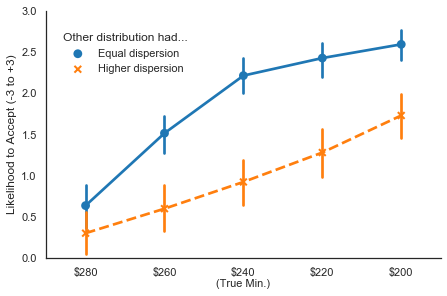

In [6]:
df6_long = pd.read_csv("../Data/Study 6/LongData.csv")
plot_lta_offer_sequential(df6_long)

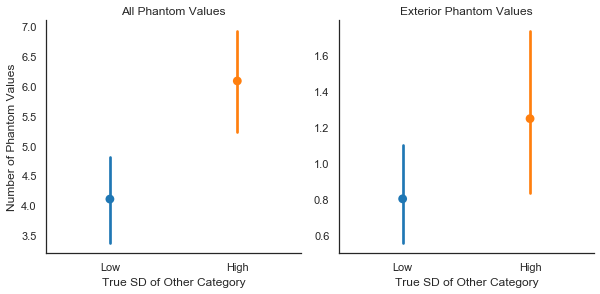

In [229]:
plot_phantom_results_s5(df4)

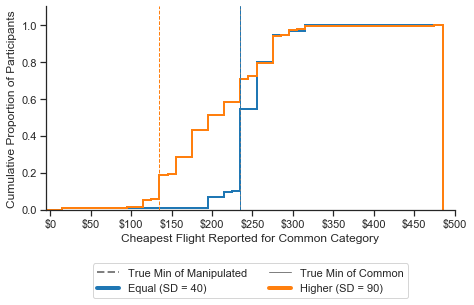

In [230]:
df6 = pd.read_csv("../Data/Study 6/CleanData.csv")
plot_minprice_cdf_sequential_s6(df6)

## Data loading and preparation

In [7]:
# Study 1
ARRAYS = {
    'Med': np.array([17, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 
                     26, 26, 27, 27, 28, 28, 29, 29, 30, 31, 32, 33, 34]),
    'High': np.array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 
                      26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]),
    'Low': np.array([23, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 
                     26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 28])
}
df1 = pd.read_csv("../Data/Study 1/LongData.csv")
df1["actual_min"] = df1.apply(
    lambda x: ARRAYS[x.sd_manipulated].min() if x.is_manipulated else ARRAYS["Med"].min(),
    axis=1)
df1["actual_max"] = df1.apply(
    lambda x: ARRAYS[x.sd_manipulated].max() if x.is_manipulated else ARRAYS["Med"].max(),
    axis=1)


df1["below_actual_min"] = (df1.memory_min < df1.actual_min)*1
df1["above_actual_max"] = (df1.memory_max > df1.actual_max)*1

df1["actual_range"] = df1["actual_max"] - df1["actual_min"]
df1["wider_actual_range"] = (df1.memory_range > df1.actual_range)*1

df1["above_actual_min"] = (df1.memory_min > df1.actual_min)*1
df1["below_actual_max"] = (df1.memory_max < df1.actual_max)*1

df1["is_manipulated_label"] = df1.is_manipulated.map({0: "Common", 1: "Manipulated"})

df1 = df1[df1.valid_response]

# Study 2
df2_dists = pd.read_csv("../Data/Study 2/LongData.csv")
df2_dists["distname"] = df2_dists.is_manipulated.apply(lambda x: "Manipulated" if x == True else "Common")

df2 = (df2_dists
          .groupby(["turkid", "name_manipulated", "is_manipulated", "sd_manipulated"])
          .agg({"value":{
              "sd":np.std, 
              "range":lambda x: np.max(x) - np.min(x), 
              "min": np.min, 
              "max":np.max, 
              "mean":np.mean, 
              "mode":lambda x: mode(x)[0], 
              "median": np.median, 
              "var":lambda x: np.std(x)**2,
              "iqr": iqr}})
          .reset_index()
         )
df2.columns = ['_'.join(col).strip("_") for col in df2.columns.values]

# Study 3
df3_dists = pd.read_csv("../Data/Study 3/LongData.csv")
df3_dists["distname"] = df3_dists.is_manipulated.apply(lambda x: "Manipulated" if x == True else "Common")

df3 = (df3_dists
          .groupby(["turkid", "name_manipulated", "is_manipulated", "mean_manipulated"])
          .agg({"value":{
              "sd":np.std, 
              "range":lambda x: np.max(x) - np.min(x), 
              "min": np.min, 
              "max":np.max, 
              "mean":np.mean, 
              "mode":lambda x: mode(x)[0], 
              "median": np.median, 
              "var":lambda x: np.std(x)**2,
              "iqr": iqr}})
          .reset_index()
         )
df3.columns = ['_'.join(col).strip("_") for col in df3.columns.values]

# Study 4
df4_dists = pd.read_csv("../Data/Study 4/LongData.csv")
dists_4 = {
    "Low": np.array([18.0, 19.0, 19.0, 20.0, 20.0, 21.0, 21.0, 21.0, 
                     22.0, 22.0, 22.0, 23.0, 23.0, 23.0, 24.0, 24.0, 24.0,
                     25.0, 25.0, 25.0, 26.0, 26.0, 27.0, 27.0, 28.0])+2,
    "High": np.array([10.0, 13.0, 15.0, 17.0, 18.0, 20.0, 21.0, 22.0, 24.0,
                      25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 34.0, 
                      35.0, 36.0, 38.0, 39.0, 41.0, 43.0, 46.0])-3
}
df4_dists["phantom_total"] =  df4_dists.apply(is_phantom_values_total, axis=1)
df4_dists["phantom_outside"] =  df4_dists.apply(is_phantom_values_outside, axis=1)
df4 = (df4_dists
       .groupby(["turkid", "pid", "item", "sd_focal", "sd_other"])
       .agg({"phantom_outside":np.sum,
             "phantom_total": np.sum,
             "value":{
              "sd":np.std, 
              "range":lambda x: np.max(x) - np.min(x), 
              "min": np.min, 
              "max":np.max, 
              "mean":np.mean, 
              "mode":lambda x: mode(x)[0], 
              "median": np.median, 
              "var":lambda x: np.std(x)**2,
              "iqr": iqr}})
          .reset_index()
         )
df4.columns = ['_'.join(col).strip("_") for col in df4.columns.values]

# Study 5
df5_dists = pd.read_csv("../Data/Study 5/LongData.csv")
df5_dists_sim = df5_dists.loc[df5_dists.similarity == "Similar"]
df5_dists_dissim = df5_dists.loc[df5_dists.similarity == "Dissimilar"]
dists_5 = {
    "Low": np.array([18.0, 19.0, 19.0, 20.0, 20.0, 21.0, 21.0, 21.0, 
                     22.0, 22.0, 22.0, 23.0, 23.0, 23.0, 24.0, 24.0, 24.0,
                     25.0, 25.0, 25.0, 26.0, 26.0, 27.0, 27.0, 28.0])+2,
    "High": np.array([10.0, 13.0, 15.0, 17.0, 18.0, 20.0, 21.0, 22.0, 
                      24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 
                      34.0, 35.0, 36.0, 38.0, 39.0, 41.0, 43.0, 46.0])-3
}

df5 = (df5_dists
       .groupby(["turkid", "pid", "item", "sd_focal", "sd_other", "similarity"])
       .agg({"value":{
              "sd":np.std, 
              "range":lambda x: np.max(x) - np.min(x), 
              "min": np.min, 
              "max":np.max, 
              "mean":np.mean, 
              "mode":lambda x: mode(x)[0], 
              "median": np.median, 
              "var":lambda x: np.std(x)**2,
              "iqr": iqr}})
          .reset_index()
         )
df5.columns = ['_'.join(col).strip("_") for col in df5.columns.values]

# Study 2 - History of distributions
df2_clean = pd.read_pickle("../Data/Study 2/CleanData.pickle")
df2_clean["history_values"] = df2_clean.history.apply(process_history_data)
df2_clean["true_sd"] = df2_clean.apply(lambda x: 4.5 if ((x.is_distractor == False) or (x.sd_distractor == "Med")) else 1.1 if x.sd_distractor == "Low" else 7.5, axis=1)
df2_clean["final_sd"] = df2_clean.dist.apply(lambda x: np.std(x))
df2_clean["final_mean"] = df2_clean.dist.apply(lambda x: np.mean(x))
df2_clean["abs_diff_sd"] = np.abs(df2_clean["true_sd"] - df2_clean.final_sd)
df2_clean["abs_diff_m"] = np.abs(25 - df2_clean.final_mean)

df2_hist = (df2_clean
            .set_index(['pid', 'is_distractor', 'sd_distractor', "abs_diff_sd", 
                        "abs_diff_m", "final_mean", "final_sd"])['history_values']
            .apply(pd.Series)
            .stack()
            .reset_index())
df2_hist.columns = ['pid', 'is_manipulated', 'sd_manipulated', "abs_diff_sd", 
                    "abs_diff_m", 'final_mean', 'final_sd', 
                    'timestamp', 'value']
df2_hist["loc_first_value"] = (df2_hist # Location of first value in distribution.
                               .groupby(["pid", "is_manipulated"])
                               .value
                               #.transform(lambda x: np.where(np.sort(x) == x.iloc[0])[0][0]))
                               .transform(lambda x: np.mean(np.where(np.sort(x) == x.iloc[0])[0])))

df2_parts = df2_hist.groupby(["pid", "is_manipulated", "sd_manipulated"]).mean().reset_index()

In [8]:
plot_cdf_stats_sequential_s1(df1, figname="CDF Min")
plot_cdf_stats_sequential_s1(df1, figname="CDF Max", fignum=2, stats="max")

# Data Transformation of Distribution Builder Data

In those studies, participants reported two distributions on two separate distribution builders, by spreading a fixed number of markers (representing bottles of wine) across different possible buckets (representing prices). 

![Demo](../Figures/DistbuilderDemo/demo.png)

In the example above, the participant has allocated:
* 1 marker to price \$13
* 1 marker to price \$15
* 2 markers to price \$17
* 5 markers to price \$19
* 8 markers to price \$21
* 5 markers to price \$23
* 2 markers to price \$25
* 1 marker to price \$27
* 1 marker to price \$29

The distribution corresponding to this allocation is therefore: 

[13, 15, 17, 17, 19, 19, 19, 19, 19, 21, 21, 21, 21, 21, 21, 21, 21, 23, 23, 23, 23, 23, 25, 25, 27, 29].

We then calculated, for each of the two distributions reported by participants, summary statistics of interest (e.g. the standard deviation in Study 2, the mean in Study 3). 

Those summary statistics constitute our dependent variables.

# Supplementary  Analysis and Graphs

## Study 2

Participants saw two distributions of wine prices: one for pillows and the other for blankets.
* One distribution (the "Common" distribution) had constant dispersion across subjects ($\sigma = 4.5$)
* The other (the "Manipulated" distribution) had a variable level of dispersion manipulated between subjects ($\sigma_{L} = 1.1$, $\sigma_{M} = 4.5$, $\sigma_{H} = 7.5$)

All distributions had a constant mean ($\mu = 25$).

The graph below describes the distributions reported by participants:

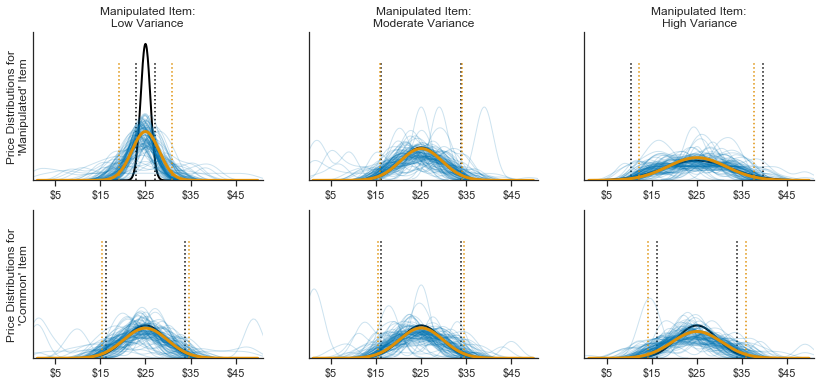

In [86]:
plot_dists_s2(df2_dists)

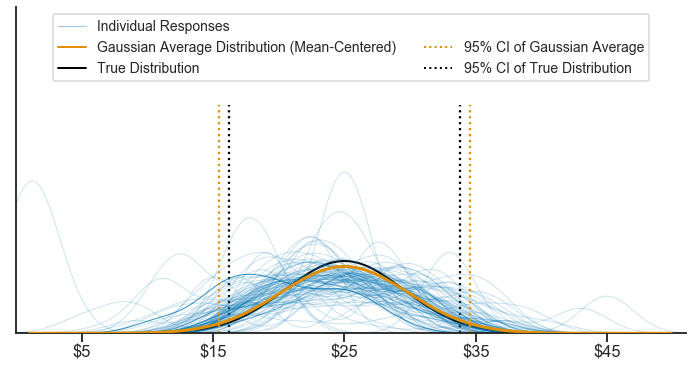

In [27]:
plot_dists_s2_sequential(df2_dists)

In [78]:
d = df2_dists[(df2_dists.is_manipulated == False) & (df2_dists.sd_manipulated == "Med")]
dsec = d[d.turkid == "A1XOG82RCTNFL7"]

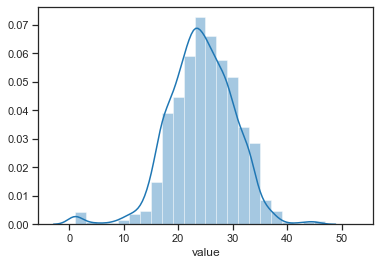

In [80]:
sns.distplot(d.value, bins=np.arange(1,54, 2))

For each distribution reported by participants, we computed the following statistics of interest: 
* Mean
* Median
* Mode
* SD 
* Variance
* Interquartile Range (IQR)
* Minimum
* Maximum

We regressed those statistics on the following predictors:
* One factor indicating the type of the distribution (Dummy-coded: "Manipulated vs. Common")
* One factor indicating the amount of dispersion in the "Manipulated" distribution (Dummy-coded: "High vs. Moderate" and "Low vs. Moderate")
* The interaction of those factors
* A random intercept for each participant

The conditional effects for each of the two categories (manipulated vs. common) are presented in the table below:

In [6]:
r2 = []
for depvar in ["mean", "median", "mode", "sd", "var", "iqr", "min", "max", "range"]:
    c = smf.mixedlm(f"value_{depvar} ~ -1+C(is_manipulated, Treatment(0))+C(sd_manipulated, Treatment(2)):C(is_manipulated, Treatment(0))", 
                    df2, groups=df2.turkid).fit()
    r2.append(c)
    
    
t2 = gen_output_from_models(r2, ["Mean", "Median", "Mode", "SD", "Var", "IQR", "Min", "Max", "Range"], 
                       ['Common: Moderate', 'Manipulated: Moderate', 'Common: High vs. Moderate', 
                        'Common: Low vs. Moderate', 'Manipulated: High vs. Moderate', 
                        'Manipulated: Low vs. Moderate', 'Participants Random Effect Var'])

ResultTableStyler(t2)

,Mean,Median,Mode,SD,Var,IQR,Min,Max,Range
Common: Moderate,24.149 ***,24.120 ***,23.340 ***,4.869 ***,25.052 ***,7.005 ***,15.920 ***,32.640 ***,16.720 ***
,(0.278),(0.320),(0.484),(0.191),(3.233),(0.370),(0.381),(0.419),(0.584)
Manipulated: Moderate,24.257 ***,24.290 ***,23.660 ***,4.647 ***,23.194 ***,6.480 ***,16.180 ***,32.580 ***,16.400 ***
,(0.278),(0.320),(0.484),(0.191),(3.233),(0.370),(0.381),(0.419),(0.584)
Common: High vs. Moderate,-0.023,-0.038,-0.993,0.650 *,6.800,0.873 •,-1.451 **,1.156 •,2.607 **
,(0.394),(0.455),(0.688),(0.272),(4.596),(0.526),(0.541),(0.596),(0.831)
Common: Low vs. Moderate,0.027,0.237,0.558,0.035,5.033,0.031,-0.083,0.054,0.137
,(0.394),(0.455),(0.688),(0.272),(4.596),(0.526),(0.541),(0.596),(0.831)
Manipulated: High vs. Moderate,0.501,0.598,-1.415 *,1.860 ***,20.065 ***,3.244 ***,-2.609 ***,3.298 ***,5.906 ***
,(0.394),(0.455),(0.688),(0.272),(4.596),(0.526),(0.541),(0.596),(0.831)


We observe the following:
* People's impression of dispersion for the manipulated distribution is appropriately affected by the amount of dispersion presented in this distribution.
* A High (vs. Medium) amount of dispersion in the manipulated distribution has a significant impact on the subjective amount of dispersion for the common distribution. This effect is directionally consistent across different operationalizations of dispersion (SD, var, IQR, min, max, range). 



## Study 3

Participants saw two distributions of wine prices: one for red wines and the other for white wines.
* One distribution (the "Common" distribution) had constant mean across subjects ($\mu = 25$)
* The other (the "Manipulated" distribution) had a variable mean manipulated between subjects ($\mu_{L} = 15$, $\mu_{M} = 25$, $\mu_{H} = 35$)

All distributions had a constant amount of dispersion ($\sigma = 4.5$).

The graph below describes the distributions reported by participants:

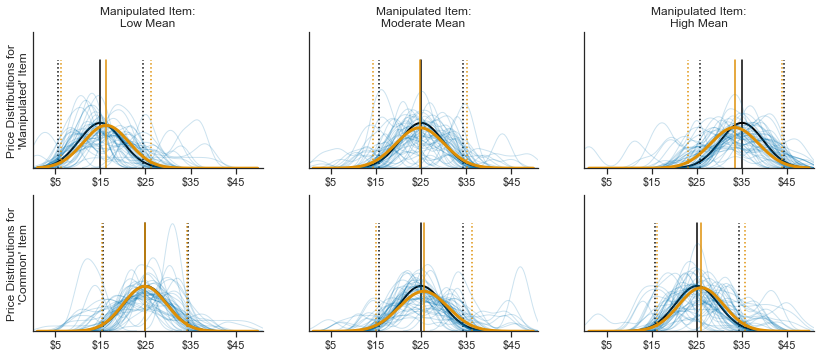

In [135]:
plot_dists_s3(df3_dists)

For each distribution reported by participants, we computed the following statistics of interest: 
* Mean
* Median
* Mode
* SD 
* Variance
* Interquartile Range (IQR)
* Minimum
* Maximum

We regressed those statistics on the following predictors:
* One factor indicating the type of the distribution (Dummy-coded: "Manipulated vs. Common")
* One factor indicating the mean of the "Manipulated" distribution (Dummy-coded: "High vs. Moderate" and "Low vs. Moderate")
* The interaction of those factors
* A random intercept for each participant

The conditional effects for each of the two categories (manipulated vs. common) are presented in the table below:

In [8]:
r3 = []
for depvar in ["mean", "median", "mode", "sd", "var", "iqr", "min", "max", "range"]:
    c = smf.mixedlm(f"value_{depvar} ~ -1+C(is_manipulated, Treatment(0))+C(mean_manipulated, Treatment(2)):C(is_manipulated, Treatment(0))", 
                    df3, groups=df3.turkid).fit()
    r3.append(c)
    
t3 = gen_output_from_models(r3, ["Mean", "Median", "Mode", "SD", "Var", "IQR", "Min", "Max", "Range"], 
                       ['Common: Moderate', 'Manipulated: Moderate', 'Common: High vs. Moderate', 
                        'Common: Low vs. Moderate', 'Manipulated: High vs. Moderate', 
                        'Manipulated: Low vs. Moderate', 'Participants Random Effect Var'])

ResultTableStyler(t3)

,Mean,Median,Mode,SD,Var,IQR,Min,Max,Range
Common: Moderate,25.539 ***,25.694 ***,24.469 ***,5.424 ***,34.030 ***,7.959 ***,16.429 ***,34.429 ***,18.000 ***
,(0.520),(0.585),(0.828),(0.313),(4.434),(0.585),(0.673),(0.765),(1.020)
Manipulated: Moderate,24.731 ***,24.959 ***,24.265 ***,5.358 ***,34.781 ***,7.837 ***,15.449 ***,33.000 ***,17.551 ***
,(0.520),(0.585),(0.828),(0.313),(4.434),(0.585),(0.673),(0.765),(1.020)
Common: High vs. Moderate,0.414,-0.002,0.492,-0.442,-5.995,-0.575,1.610 •,0.148,-1.462
,(0.725),(0.815),(1.154),(0.436),(6.179),(0.815),(0.938),(1.066),(1.421)
Common: Low vs. Moderate,-0.677,-0.944,-0.803,-0.605,-9.008,-1.043,0.405,-0.929,-1.333
,(0.739),(0.832),(1.177),(0.445),(6.303),(0.831),(0.957),(1.088),(1.450)
Manipulated: High vs. Moderate,8.625 ***,8.233 ***,7.504 ***,-0.032,-3.614,-0.183,8.859 ***,9.692 ***,0.834
,(0.725),(0.815),(1.154),(0.436),(6.179),(0.815),(0.938),(1.066),(1.421)


We observe the following:
* The true mean of the manipulated distribution has a significant impact on the mean of the manipulated distribution reported by participants. 
* In contrast, the mean, median or mode of the common distribution that participants report are not affected by the mean of the "Manipulated" distribution, which suggests that participants made a distinction between the central tendency of the two distributions.
* Mean-independent statistics of dispersion (SD, var, IQR and range) are also not affected by our manipulations of the mean, which is inconsistent with what an exemplar-based model of judgment would have predicted.

## Study 4

Participants saw two distributions of wine prices: one for red wines and the other for white wines. 
* The variance of each distribution was orthogonally manipulated between-subjects to be "Low" ($\sigma_{L} = 1.78$) or "High" ($\sigma_{H} = 5.37$)
* The mean price of each distribution was held constant between-subjects, and was such that the two distributions did not overlap: ($\mu_{\text{White}} = 12$, $\mu_{\text{Red}} = 38$)

The graph below describes the distributions reported by participants:

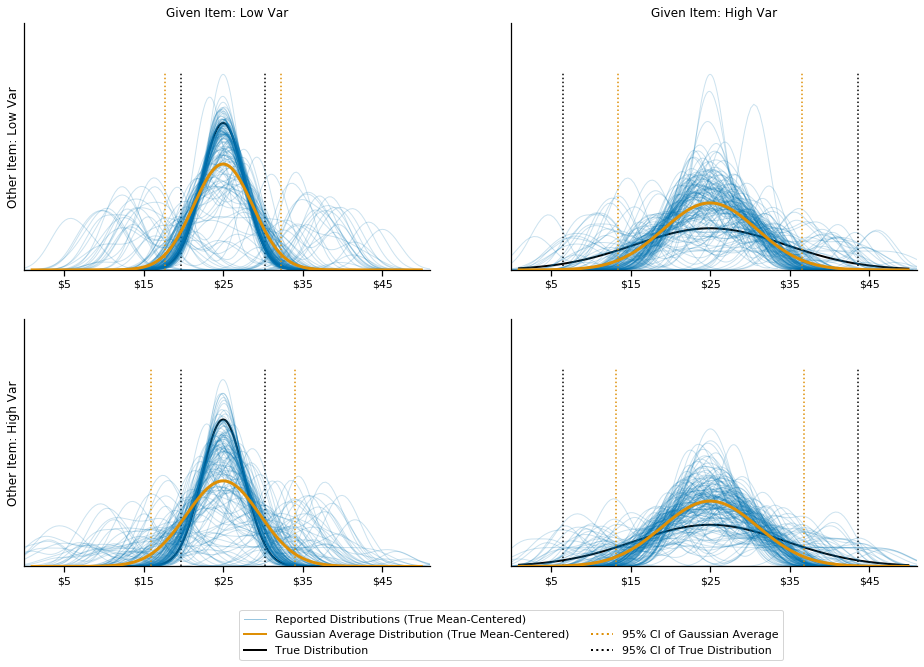

In [9]:
plot_dists_fourcells(df4_dists, dists_4)


For each distribution reported by participants, we computed the following statistics of interest: 
* Mean
* Median
* Mode
* SD 
* Variance
* Interquartile Range (IQR)
* Minimum
* Maximum


We regressed those statistics on the following predictors:
* One factor indicating the dispersion of this "Given" distribution ("Low": -0.5, "High": 0.5)
* One factor indicating the dispersion of the "Other" distribution that the participant learned ("Low": -0.5, "High": 0.5)
* The interaction of those factors
* A random intercept for each participant

The results are presented in the table below:

In [10]:
r4 = []
for depvar in ["mean", "median", "mode", "sd", "var", "iqr", "min", "max", "range"]:
    c = smf.mixedlm(f"value_{depvar} ~ C(sd_focal, Diff, levels=['Low', 'High'])*C(sd_other, Diff, levels=['Low', 'High'])", 
                    df4, groups=df4.turkid).fit()
    r4.append(c)
    
t4 = gen_output_from_models(r4, ["Mean", "Median", "Mode", "SD", "Var", "IQR", "Min", "Max", "Range"], 
                       ["Intercept", "Given Item: High vs. Low SD", "Other Item: High vs. Low SD", 
                        "Cumulative Impact of High vs. Low SD", 'Participants Random Effect Var'])

ResultTableStyler(t4)

,Mean,Median,Mode,SD,Var,IQR,Min,Max,Range
Intercept,22.904 ***,22.994 ***,21.876 ***,5.061 ***,35.165 ***,7.548 ***,14.678 ***,31.121 ***,16.442 ***
,(0.467),(0.487),(0.589),(0.152),(2.256),(0.289),(0.538),(0.596),(0.416)
Given Item: High vs. Low SD,-0.281,-0.395,-1.226,1.792 ***,14.340 ***,2.362 ***,-3.495 ***,3.198 **,6.692 ***
,(0.931),(0.971),(1.096),(0.258),(3.839),(0.494),(1.002),(1.089),(0.707)
Other Item: High vs. Low SD,-0.549,-0.367,-0.336,0.516 *,3.941,0.407,-2.002 *,0.581,2.583 ***
,(0.931),(0.971),(1.096),(0.258),(3.839),(0.494),(1.002),(1.089),(0.707)
Cumulative Impact of High vs. Low SD,0.126,-0.297,0.190,-0.737,-8.084,-0.718,1.371,-1.079,-2.450
,(1.869),(1.949),(2.357),(0.608),(9.025),(1.155),(2.150),(2.384),(1.665)
Participants Random Effect Var,0.970,1.152,27.428,3.785,821.876,13.136,22.103,34.126,28.128
,N.C.,N.C.,N.C.,(0.319),(4.702),(0.594),N.C.,N.C.,(0.870)


As the distributions of Means, Median, Mode, Maximum, and Minimum are bimodal, some convergence issues arise when estimating parameters in the mixed linear model (indicated by N.C. in the table).

An OLS specification gives similar results:

In [11]:
r4_OLS = []
for depvar in ["mean", "median", "mode", "sd", "var", "iqr", "min", "max", "range"]:
    c = smf.ols(f"value_{depvar} ~ C(sd_focal, Diff, levels=['Low', 'High'])*C(sd_other, Diff, levels=['Low', 'High'])", 
                    df4).fit()
    r4_OLS.append(c)
    
t4_OLS = gen_output_from_OLS_models(r4_OLS, ["Mean", "Median", "Mode", "SD", "Var", "IQR", "Min", "Max", "Range"], 
                       ["Intercept", "Given Item: High vs. Low SD", "Other Item: High vs. Low SD", 
                        "Cumulative Impact of High vs. Low SD"])

ResultTableStyler(t4_OLS)

,Mean,Median,Mode,SD,Var,IQR,Min,Max,Range
Intercept,22.904 ***,22.994 ***,21.876 ***,5.061 ***,35.165 ***,7.548 ***,14.678 ***,31.121 ***,16.442 ***
,(0.464),(0.484),(0.518),(0.130),(1.929),(0.248),(0.476),(0.503),(0.355)
Given Item: High vs. Low SD,-0.281,-0.395,-1.226,1.792 ***,14.340 ***,2.362 ***,-3.495 ***,3.198 **,6.692 ***
,(0.928),(0.967),(1.037),(0.259),(3.857),(0.496),(0.952),(1.005),(0.711)
Other Item: High vs. Low SD,-0.549,-0.367,-0.336,0.516 *,3.941,0.407,-2.002 *,0.581,2.583 ***
,(0.928),(0.967),(1.037),(0.259),(3.857),(0.496),(0.952),(1.005),(0.711)
Cumulative Impact of High vs. Low SD,0.126,-0.297,0.190,-0.737,-8.084,-0.718,1.371,-1.079,-2.450 •
,(1.856),(1.935),(2.074),(0.519),(7.715),(0.992),(1.903),(2.011),(1.421)


We replicate the dispersion spillover, in a context where the two distributions do not overlap:
* The dispersion of a "Given" distribution has a significant impact on the dispersion of prices reported by participants for this "Given" distribution. 
* The dispersion of the "Other" distribution that was simultaneously presented also affects the dispersion of prices reported by participants.
* Those effects are directionally consistent across different operationalizations of dispersion (SD, var, IQR, min, max, range).

## Study 5

Participants saw two distributions of prices.

* We manipulated between-subjects the label assigned to each distribution so that they describe "Similar" products (white wines/red wines) or "Dissimilar" products (smartphone cases/red wines)
* The variance of each distribution was orthogonally manipulated between-subjects to be "Low" ($\sigma_{L} = 2.7$) or "High" ($\sigma_{H} = 9.6$)
* The mean price of each distribution was held constant between-subjects ($\mu_{\text{White/Smartphones}} = 23$, $\mu_{\text{Red}} = 28$)

The graph below describes the distributions reported by participants in the "Similar" and "Dissimilar" conditions:


### Similar items

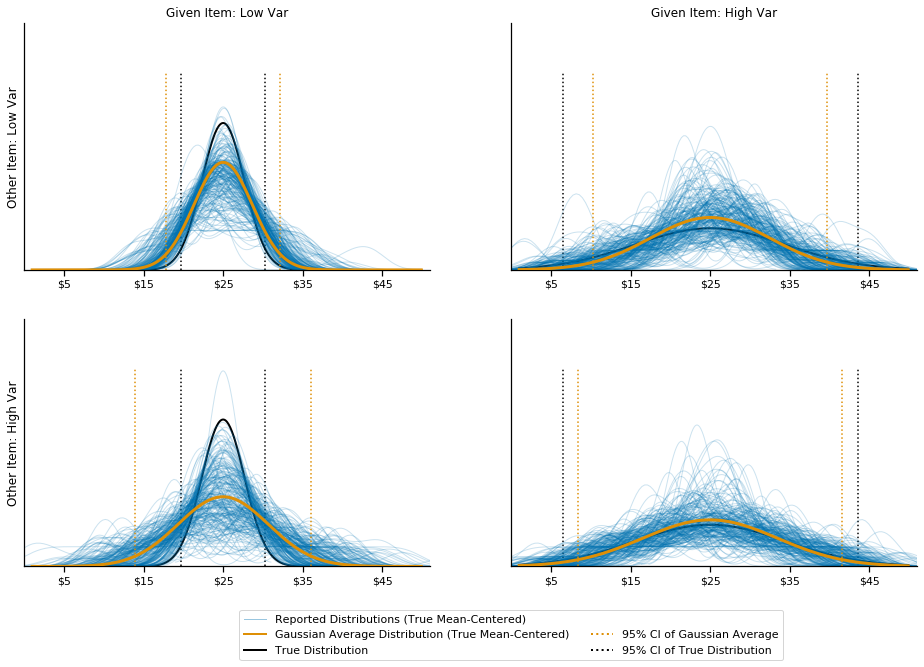

In [12]:
plot_dists_fourcells(df5_dists_sim, dists_5)

### Dissimilar items

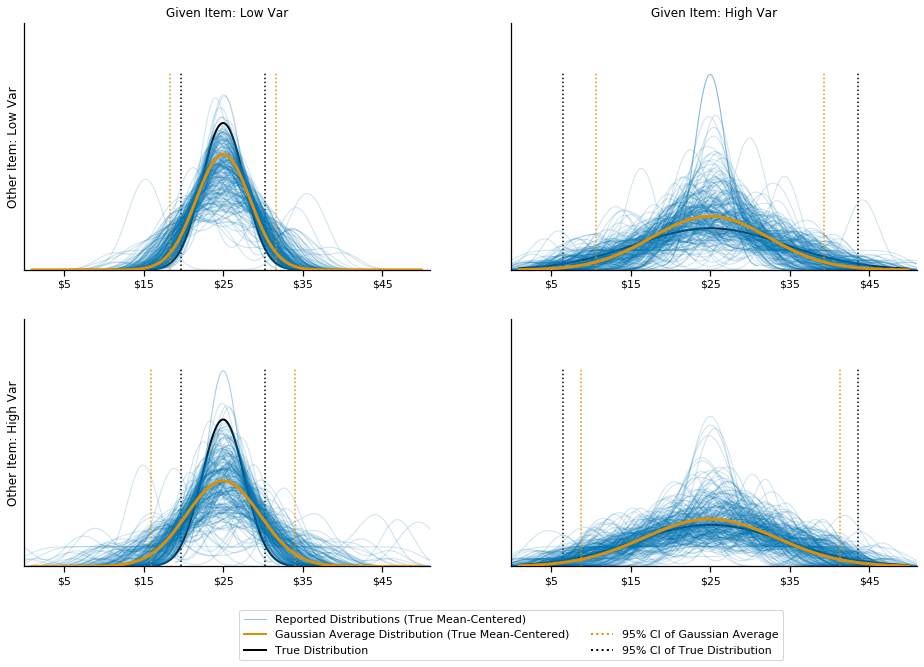

In [13]:
plot_dists_fourcells(df5_dists_dissim, dists_5)

For each distribution reported by participants, we computed the following statistics of interest: 
* Mean
* Median
* Mode
* SD 
* Variance
* Interquartile Range (IQR)
* Minimum
* Maximum


We regressed those statistics on the following predictors:
* One factor indicating the dispersion of this "Given" distribution ("Low": -0.5, "High": 0.5)
* One factor indicating the dispersion of the "Other" distribution that the participant learned ("Low": -0.5, "High": 0.5)
* The interaction of those factors
* A random intercept for each participant

The results are presented in the table below:

In [14]:
r5 = []
for depvar in ["mean", "median", "mode", "sd", "var", "iqr", "min", "max", "range"]:
    c = smf.mixedlm(f"value_{depvar} ~ \
    C(sd_focal, Diff, levels=['Low', 'High'])*\
    C(sd_other, Diff, levels=['Low', 'High'])*\
    C(similarity, Diff, levels=['Dissimilar', 'Similar'])", 
                    df5, groups=df5.turkid).fit()
    r5.append(c)
    
t5 = gen_output_from_models(r5, ["Mean", "Median", "Mode", "SD", "Var", "IQR", "Min", "Max", "Range"], 
                       ["Intercept", "Given Item: High vs. Low SD", 
                        "Other Item: High vs. Low SD", 
                        "Cumulative Impact of High vs. Low SD",
                        "Similarity: Similar vs. Dissimilar", 
                        "Given Item × Similarity", 
                        "Other Item × Similarity", 
                        "Cumulative Impact × Similarity", 
                        "Participants Random Effects Var"])

ResultTableStyler(t5)

,Mean,Median,Mode,SD,Var,IQR,Min,Max,Range
Intercept,25.568 ***,25.594 ***,24.259 ***,6.118 ***,43.669 ***,8.378 ***,14.427 ***,36.289 ***,21.862 ***
,(0.103),(0.113),(0.161),(0.059),(0.815),(0.104),(0.133),(0.150),(0.207)
Given Item: High vs. Low SD,0.093,0.268,-0.644 *,3.571 ***,42.678 ***,4.780 ***,-7.055 ***,6.322 ***,13.377 ***
,(0.205),(0.226),(0.317),(0.100),(1.414),(0.186),(0.253),(0.283),(0.354)
Other Item: High vs. Low SD,0.132,0.137,-0.718 *,1.276 ***,15.814 ***,2.026 ***,-1.927 ***,2.207 ***,4.134 ***
,(0.205),(0.226),(0.317),(0.100),(1.414),(0.186),(0.253),(0.283),(0.354)
Cumulative Impact of High vs. Low SD,-0.069,-0.131,-0.737 *,0.413 ***,3.767 *,0.478 *,-0.596 *,1.003 ***,1.599 ***
,(0.205),(0.226),(0.322),(0.117),(1.631),(0.208),(0.267),(0.300),(0.415)
Similarity: Similar vs. Dissimilar,0.159,-0.019,-0.406,-0.633 **,-3.796,-0.033,2.014 ***,-1.389 *,-3.403 ***
,(0.411),(0.451),(0.644),(0.235),(3.261),(0.417),(0.533),(0.600),(0.830)


We observe the following:
* The dispersion of a "Given" distribution has a significant impact on the dispersion of prices reported by participants for this "Given" distribution. 
* The dispersion of the "Other" distribution that was simultaneously presented also affects the dispersion of prices reported by participants.
* The impact of the "Given" distribution is weaker (stronger) for items that are similar (dissimilar)
* The impact of the "Other" distribution is stronger (weaker) for items that are similar (dissimilar)
* Those effects are directionally consistent across different operationalizations of dispersion (SD, var, IQR, min, max, range).

# How do People Construct Distributions?

In study 2, we recorded how people construct distributions over time.

Participants exhibit a fair amount of heterogeneity in the way they construct the distribution: some start from the bottom, some start from the top, and some start from the middle of the distribution. 

The graph below visualizes four clusters of "construction strategy".

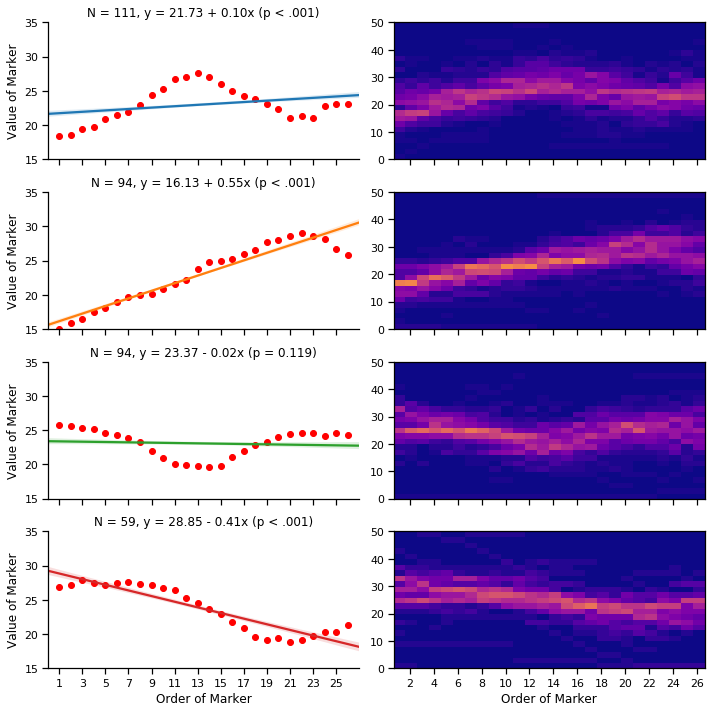

In [15]:
# Constructing the history data
data = []
for p in df2_hist.pid.unique()[0:]:
    for k in [False, True]:
        d = df2_hist[(df2_hist.pid==p) & (df2_hist.is_manipulated == k)].copy()
        v = d.value.values
        if len(v) != 0:
            data.append(v)
            
data = np.array(data)

# Standardizing the data before clustering
data_std = data.T 
data_std = (data_std - np.mean(data_std, axis=0))/np.std(data_std, axis=0)
isnan = np.isnan(data_std).max(axis=0)
data_std = data_std[:,~isnan].T

# Clustering and aggregating
p = KernelPCA(25, kernel="linear").fit(data_std)
dnew = p.transform(data_std)
N_CLUSTERS = 4
kmeans = KMeans(init='k-means++', n_clusters=N_CLUSTERS, n_init=10)
kmeans.fit(dnew)
clusters = kmeans.predict(dnew)

# Plotting
fig, ax = plt.subplots(N_CLUSTERS, 2, figsize=(10, 10), sharex="col", sharey="col")
for i, c in enumerate(np.unique(clusters)):
    d = data[~isnan][clusters == c]
    r = d.shape[0]
    x = np.repeat(np.arange(0, 26, 1), r)
    y = d.T.flatten()
    mod = OLS(y, add_constant(x)).fit()
    _, _, _, cs = ax[i][1].hist2d(np.tile(np.arange(0, 26, 1), r), (d).flatten(), 
                                  bins=[np.arange(0, 27, 1)-0.1, np.arange(0, 53, 2)], 
                                  cmap="plasma", 
                                  normed=True, vmax=0.009)
    ax[i][0].scatter(np.arange(0, 26, 1), d.mean(axis=0), color="r")
    sns.regplot(x, y, scatter_kws={"alpha":0.1}, scatter=False, ax=ax[i][0])
    sign = "+" if mod.params[1] > 0 else "-"
    pval = mod.pvalues[1]
    ptext = f"(p = {pval:.3f})" if pval > .001 else "(p < .001)"
    ax[i][0].set_title(f"N = {r}, y = {mod.params[0]:.2f} {sign} {np.abs(mod.params[1]):.2f}x {ptext}")
    ax[i][0].set_ylim(15, 35)
    ax[i][1].set_ylim(0, 50)
    ax[i][0].set_ylabel("Value of Marker")
    sns.despine(ax=ax[i][0])
ax[3][1].set_xticks(np.arange(1, 26, 2)+0.25)
ax[3][1].set_xticklabels(np.arange(2, 28, 2))
ax[3][0].set_xticks(np.arange(0, 25, 2))
ax[3][0].set_xticklabels(np.arange(1, 27, 2))
ax[0][0].set_xlim(-1, 26)
ax[3][0].set_xlabel("Order of Marker")
ax[3][1].set_xlabel("Order of Marker")
ax[3][1].set_xlabel("Order of Marker")
plt.tight_layout()

We do not find that construction strategy (operationalized by the ordinal position of the first marker entered within the final distribution) is significantly correlated to the accuracy of the final distribution.

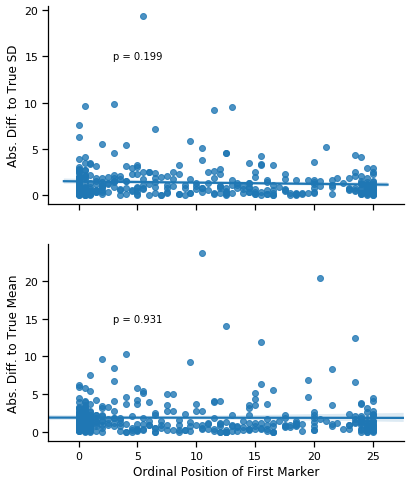

In [16]:
pal = sns.color_palette()
fig, axes = plt.subplots(2, 1, figsize=(6.38, 8), sharex=True)
sns.regplot(data=df2_parts, x="loc_first_value", y="abs_diff_sd", ax=axes[0], color=pal[0])
sns.regplot(data=df2_parts, x="loc_first_value", y="abs_diff_m", ax=axes[1], color=pal[0])
pval_sd = smf.ols("abs_diff_sd ~ loc_first_value", data=df2_parts).fit().pvalues[1]
pval_m = smf.ols("abs_diff_m ~ loc_first_value", data=df2_parts).fit().pvalues[1]

axes[0].set_xlabel("")
axes[0].annotate(f"p = {pval_sd:.3f}", (5, 15), ha="center", va="center")
axes[0].set_ylabel("Abs. Diff. to True SD")

axes[1].set_xlabel("")
axes[1].annotate(f"p = {pval_m:.3f}", (5, 15), ha="center", va="center")
axes[1].set_ylabel("Abs. Diff. to True Mean")
axes[1].set_xlabel("Ordinal Position of First Marker")

sns.despine()

In [121]:
x1 = np.random.normal(120, 20, 100)
x2 = np.random.normal(200, 50, 50)
x = np.hstack([x1, x2])

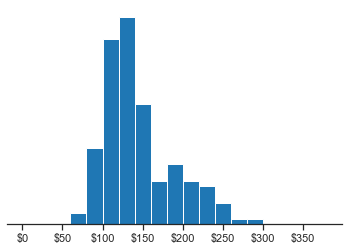

In [122]:
import matplotlib.ticker as ticker
plt.hist(x, bins=np.arange(0, 400, 20), align="mid")
sns.despine(left=True)
ax = plt.gca()
ax.set_yticks([])
@ticker.FuncFormatter
def dollar_formatter(x, pos):
    return f"${x:.0f}"
ax.xaxis.set_major_formatter(dollar_formatter)